# ECS7026P Neural Networks and Deep Learning - 2022/23 : Coursework 1


    Name: Mohammed Ataaur Rahaman
    Student Number: 220843052
    email: m.a.rahaman@se22.qmul.ac.uk
    Assignment Number: Coursework 1
    Module Code: ECS6P9U/P/7026P
    Module Name: Neural Networks and Deep Learning 

Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

from torch import nn
from tqdm.auto import tqdm

In [2]:
!nvidia-smi

Fri Mar 31 13:37:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  On   | 00000000:12:00.0 Off |                    0 |
| N/A   34C    P0    43W / 300W |      0MiB /  4915MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Gathering

In [3]:
transform_train = transforms.Compose([transforms.Resize((32,32)),  #resises the image so it can be perfect for our model.
                                      transforms.RandomHorizontalFlip(), # FLips the image w.r.t horizontal axis
                                      transforms.RandomRotation(10),     #Rotates the image to a specified angel
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), #Performs actions like zooms, change shear angles.
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Set the color params
                                      transforms.ToTensor(), # comvert the image to tensor so that it can work with torch
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
                               ])
 

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# transform = transforms.Compose([transforms.ToTensor()])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

In [6]:
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
# testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

In [7]:
testset, trainset

(Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ),
 Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ))

## Data Preprocessing

In [8]:
BATCH_SIZE = 8
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

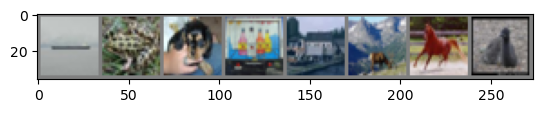

ship  frog  dog   truck truck deer  horse bird 


In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{CLASSES[labels[j]]:5s}' for j in range(BATCH_SIZE)))


## Model

In [10]:
# Parameters 


N = 2
IMG_DIM = 32
IMG_CHANNELS = 3
HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 5
STRIDE = 1

In [11]:
class ConvBlock(nn.Sequential):

    def __init__(self, in_channels=IMG_CHANNELS, out_channels=HIDDEN_CHANNELS, kernel_size=HIDDEN_CONV_KERNEL):
        
        super(ConvBlock, self).__init__(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            #nn.AvgPool2d(kernel_size=2, stride=2, padding=0),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Dropout2d(p=0.25),
        )

In [12]:
class Backbone(nn.Module):

    def __init__(self, in_channels=IMG_CHANNELS, out_channels=HIDDEN_CHANNELS, kernel_size=HIDDEN_CONV_KERNEL, k=5, debug=False):
        super(Backbone, self).__init__()

        # Boolean to print debug logs.
        self.debug = debug

        self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.linear = nn.Sequential(
            nn.Linear(in_features=in_channels, out_features=k, bias=False),   # Question, can this be MLP?
            #nn.Tanh(),
            # nn.LeakyReLU(),
            # nn.Linear(in_features=k, out_features=k, bias=True),  
            #nn.ReLU(),
            nn.Sigmoid(),      # Non Linear Activation
        )

        self.conv_blocks = nn.ModuleList([
            ConvBlock(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size)
            for _ in range(k)
        ])

        self.batch_norm = nn.BatchNorm2d(num_features=out_channels)

    def forward(self, x):
        sap_out = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
        if self.debug: print(f"{sap_out.shape=}")

        g_out = self.linear(sap_out)
        if self.debug: print(f"{g_out.shape=}")
        if self.debug: print(f"{g_out=}")

        outs = list()
        for a, conv_block in zip(g_out.transpose(0, 1), self.conv_blocks):
        #for conv2d in self.conv2ds:
            c_out = conv_block(x)
            if self.debug: print(f"{c_out.shape=}")
            if self.debug: print(f"{a.shape=}, \n{a=}")

            out = a.reshape(x.shape[0], 1, 1, 1)*c_out
            if self.debug: print(f"{out.shape=}")
            outs.append(out)
            #outs.append(c_out)

        out = sum(outs)
        if self.debug: print(f"{out.shape=}")

        out = self.batch_norm(out)
        if self.debug: print(f"{batch_out.shape=}")

        return out

In [13]:
class Classifier(nn.Module):
    
    def __init__(self, in_features, out_features, debug=True):
        
        super(Classifier, self).__init__()
        self.debug = debug
        
        self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        
        self.mlp = nn.Sequential(
            nn.Linear(in_features=in_features, out_features=in_features * 2 // 3, bias=False),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=in_features * 2 // 3, out_features=in_features // 3, bias=False),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(in_features=in_features // 3, out_features=len(CLASSES), bias=False),
            #nn.Linear(in_features=in_features, out_features=out_features, bias=False),
        )
        
    def forward(self, x):
        
        f = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
        if self.debug: print(f"Classifier: {f.shape=}")

        out = self.mlp(f)
        if self.debug: print(f"Classifier: {out.shape=}")

        return out

In [14]:
class Model(nn.Module):
    
    def __init__(self, channels, Ks, kernel_size=HIDDEN_CONV_KERNEL, n=N, debug=False):
        
        super(Model, self).__init__()
        
        self.debug = debug   # Boolean to print debug logs.
        self.Ks = Ks
        self.channels = channels
        self.n = n

        self.backbones = nn.ModuleList([
            Backbone(
                in_channels=self.channels[i], 
                out_channels=self.channels[i+1], 
                kernel_size=kernel_size, 
                k=self.Ks[i], 
                debug=debug
            ) 
            for i in range(self.n)
        ])
        
        self.classifier = Classifier(in_features=self.channels[-1], out_features=len(CLASSES), debug=debug)

    def set_debug(self, debug=True):
        
        self.debug = debug
        for backbone in self.backbones:
            backbone.debug = debug
        self.classifier.debug = debug

    def forward(self, x):
        
        for backbone in self.backbones:
            x = backbone(x)
    
        out = self.classifier(x)

        return out

In [15]:
class Trainer:
    
    def __init__(self, model, criterion, optimizer, trainloader, testloader, logs_per_epoch=4) -> None:
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer

        self.epochs = 0
        self.log_step = len(trainloader) // logs_per_epoch

        self.trainloader = trainloader
        self.testloader = testloader

        self.losses = list()
        self.val_losses = list()
        self.batch_losses = list()

        self.train_accuracy = list()
        self.val_accuracy = list()
        
    
    def train(self, epochs=3, use_gpu=False):
        
        correct = 0
        total = 0
        
        for epoch in range(self.epochs, self.epochs + epochs):  # loop over the dataset multiple times

            batch_losses = list()
            running_loss = 0.0
            for i, data in tqdm(enumerate(self.trainloader, 0), total=len(trainloader), desc=f"Epoch {epoch + 1} "):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                if use_gpu:
                    inputs = inputs.to('cuda')
                    labels = labels.to('cuda')

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                
                # Accuracy
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # print statistics
                batch_losses.append(loss.item())
                running_loss += loss.item()
                if i % self.log_step == self.log_step-1:    # print every 2000 mini-batches
                    avg_loss = running_loss / self.log_step
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}')
                    running_loss = 0.0
                    self.batch_losses.append(avg_loss)

            self.losses.append(sum(batch_losses) / len(batch_losses))
            print(f"Train Loss : {self.losses[-1]}")
            
            accuracy = correct / total
            self.train_accuracy.append(accuracy)
            print(f'Train Accuracy : {100 * accuracy:.2f} %')
            
            self.eval()

        self.epochs += epochs
        print('Finished Training')
    
    
    def eval(self):
        correct = 0
        total = 0
        losses = list()
        
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                if USE_GPU:
                    images = images.to('cuda')
                    labels = labels.to('cuda')

                # calculate outputs by running images through the network
                outputs = self.model(images)

                loss = self.criterion(outputs, labels)
                losses.append(loss.item())

                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                
                total += labels.size(0)
                correct += (predicted == labels).sum().item()


        val_loss = sum(losses) / len(losses)
        self.val_losses.append(val_loss)

        print(f"Val Loss : {val_loss}")

        accuracy = correct / total
        self.val_accuracy.append(accuracy)
        print(f'Accuracy of the network on the 10000 test images: {100 * accuracy:.2f} %')
    
    def plot(self):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(10, 3)

        X = np.linspace(0, len(self.losses)-1, len(self.batch_losses))
        ax1.plot(X, self.batch_losses, label="Train Batches", color='C0', linestyle='dashed', lw=1, alpha=0.7)
        ax1.plot(self.losses, label='Train', color='C0', lw=3, alpha=1)
        ax1.plot(self.val_losses, label='Test', color='C1', lw=3, alpha=1)
        ax1.legend()
        ax1.set(title=f'Loss Curve', xlabel='Epoch', ylabel='Loss')
        
        ax2.plot(self.train_accuracy, label="Train", color='C0', lw=3, alpha=1)
        ax2.plot(self.val_accuracy, label="Test", color='C1', lw=3, alpha=1)
        ax2.set(title=f'Accuracy Curve', xlabel='Epoch', ylabel='Accuracy')
        ax2.legend()
        plt.tight_layout()
        fig.show()
    

In [16]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # by checking the type we can init different layers in different ways
        torch.nn.init.xavier_uniform_(m.weight)   

In [18]:
def model_summary(model, trainloader):

    img_sizes = list()
    
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            if USE_GPU:
                images = images.to('cuda')
                labels = labels.to('cuda')
            
            x = images
            
            img_sizes.append(x.shape[-1])
            for backbone in model.backbones:
                x = backbone(x)
                img_sizes.append(x.shape[-1])
            break
                
    print(f"{model.channels=}")
    print(f"{model.Ks=}")
    print(f"{model.n=}")
    print(f"{img_sizes=}")

## Experiment

In [19]:
# Init model

IMG_DIM = 32
IMG_CHANNELS = 3
USE_GPU = True


# K = 5
# HIDDEN_CHANNELS = 16
HIDDEN_CONV_KERNEL = 3
STRIDE = 1

# channels = [IMG_CHANNELS, 16, 32, 64, 64] #20, 25, 30]
# channels = [IMG_CHANNELS, 4, 8, 16, ]
# channels = [IMG_CHANNELS, 5, 7, 9, 11, 13]
channels = [IMG_CHANNELS, 128, 256, 512, 1028] #19, ]
# Ks = channels[1:]
Ks = [3] * (len(channels) - 1)
N = len(channels) - 1

model = Model(
    Ks=Ks,
    channels=channels,
    kernel_size=HIDDEN_CONV_KERNEL, 
    n=N, 
    debug=True
)

model.apply(init_weights)

if USE_GPU: model.to('cuda')
model.set_debug(False)
model_summary(model=model, trainloader=trainloader)
model

model.channels=[3, 128, 256, 512, 1028]
model.Ks=[3, 3, 3, 3]
model.n=4
img_sizes=[32, 16, 8, 4, 2]


Model(
  (backbones): ModuleList(
    (0): Backbone(
      (spaitial_average_pool): AdaptiveAvgPool2d(output_size=(1, 1))
      (linear): Sequential(
        (0): Linear(in_features=3, out_features=3, bias=False)
        (1): Sigmoid()
      )
      (conv_blocks): ModuleList(
        (0): ConvBlock(
          (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (4): Dropout2d(p=0.25, inplace=False)
        )
        (1): ConvBlock(
          (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (4): Dropout2d(p=0.25, inplac

In [20]:
# Init optimizer 

LR = 1e-4 #1e-3, 1e-4
MOMENTUM = 0.9 #0.9


criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)

In [22]:
# Init Trainer

BATCH_SIZE = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


trainer = Trainer(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    logs_per_epoch=4,
    trainloader=trainloader,
    testloader=testloader,
)

Epoch 1 :   0%|          | 0/391 [00:00<?, ?it/s]

[1,    97] loss: 2.170
[1,   194] loss: 1.891
[1,   291] loss: 1.781
[1,   388] loss: 1.690
Train Loss : 1.8807006464589893
Train Accuracy : 30.73 %
Val Loss : 1.6318788437903682
Accuracy of the network on the 10000 test images: 39.56 %


Epoch 2 :   0%|          | 0/391 [00:00<?, ?it/s]

[2,    97] loss: 1.613
[2,   194] loss: 1.542
[2,   291] loss: 1.493
[2,   388] loss: 1.452
Train Loss : 1.5239485846760938
Train Accuracy : 37.52 %
Val Loss : 1.4444598246224318
Accuracy of the network on the 10000 test images: 47.45 %


Epoch 3 :   0%|          | 0/391 [00:00<?, ?it/s]

[3,    97] loss: 1.406
[3,   194] loss: 1.356
[3,   291] loss: 1.324
[3,   388] loss: 1.279
Train Loss : 1.340705815178659
Train Accuracy : 42.12 %
Val Loss : 1.2824950248380251
Accuracy of the network on the 10000 test images: 53.82 %
Finished Training


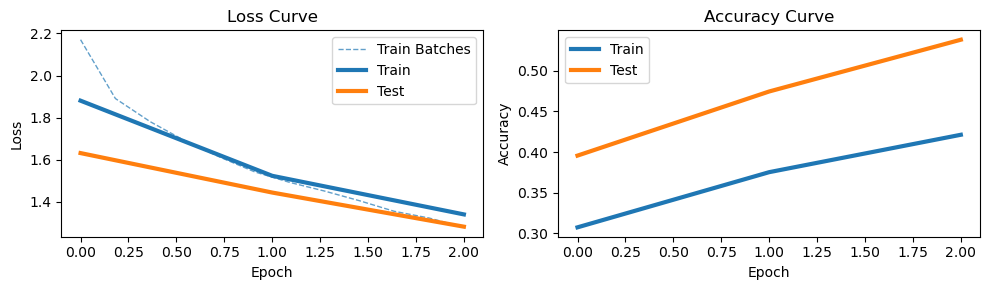

In [23]:
trainer.train(epochs=3, use_gpu=USE_GPU)
trainer.plot()

Epoch 4 :   0%|          | 0/391 [00:00<?, ?it/s]

[4,    97] loss: 1.214
[4,   194] loss: 1.207
[4,   291] loss: 1.186
[4,   388] loss: 1.138
Train Loss : 1.1858916025027595
Train Accuracy : 57.41 %
Val Loss : 1.1486701467369176
Accuracy of the network on the 10000 test images: 59.09 %


Epoch 5 :   0%|          | 0/391 [00:00<?, ?it/s]

[5,    97] loss: 1.110
[5,   194] loss: 1.094
[5,   291] loss: 1.067
[5,   388] loss: 1.017
Train Loss : 1.071867573444191
Train Accuracy : 59.46 %
Val Loss : 1.0689685329606262
Accuracy of the network on the 10000 test images: 61.93 %


Epoch 6 :   0%|          | 0/391 [00:00<?, ?it/s]

[6,    97] loss: 0.989
[6,   194] loss: 0.984
[6,   291] loss: 0.971
[6,   388] loss: 0.947
Train Loss : 0.972965393377387
Train Accuracy : 61.33 %
Val Loss : 0.9763700479193579
Accuracy of the network on the 10000 test images: 65.42 %


Epoch 7 :   0%|          | 0/391 [00:00<?, ?it/s]

[7,    97] loss: 0.919
[7,   194] loss: 0.903
[7,   291] loss: 0.887
[7,   388] loss: 0.887
Train Loss : 0.8988604690412731
Train Accuracy : 63.10 %
Val Loss : 0.9346970402741734
Accuracy of the network on the 10000 test images: 66.89 %


Epoch 8 :   0%|          | 0/391 [00:00<?, ?it/s]

[8,    97] loss: 0.848
[8,   194] loss: 0.824
[8,   291] loss: 0.828
[8,   388] loss: 0.822
Train Loss : 0.8302988045660736
Train Accuracy : 64.62 %
Val Loss : 0.8641640906092487
Accuracy of the network on the 10000 test images: 69.66 %


Epoch 9 :   0%|          | 0/391 [00:00<?, ?it/s]

[9,    97] loss: 0.778
[9,   194] loss: 0.770
[9,   291] loss: 0.769
[9,   388] loss: 0.762
Train Loss : 0.7704911758680173
Train Accuracy : 66.02 %
Val Loss : 0.832910211025914
Accuracy of the network on the 10000 test images: 71.01 %


Epoch 10 :   0%|          | 0/391 [00:00<?, ?it/s]

[10,    97] loss: 0.715
[10,   194] loss: 0.728
[10,   291] loss: 0.723
[10,   388] loss: 0.711
Train Loss : 0.7184455003732305
Train Accuracy : 67.30 %
Val Loss : 0.8066307238385647
Accuracy of the network on the 10000 test images: 71.95 %


Epoch 11 :   0%|          | 0/391 [00:00<?, ?it/s]

[11,    97] loss: 0.681
[11,   194] loss: 0.682
[11,   291] loss: 0.675
[11,   388] loss: 0.666
Train Loss : 0.6761190629828616
Train Accuracy : 68.44 %
Val Loss : 0.7689860161346725
Accuracy of the network on the 10000 test images: 73.68 %


Epoch 12 :   0%|          | 0/391 [00:00<?, ?it/s]

[12,    97] loss: 0.629
[12,   194] loss: 0.632
[12,   291] loss: 0.632
[12,   388] loss: 0.640
Train Loss : 0.6334964008739842
Train Accuracy : 69.48 %
Val Loss : 0.7556584899938559
Accuracy of the network on the 10000 test images: 73.83 %


Epoch 13 :   0%|          | 0/391 [00:00<?, ?it/s]

[13,    97] loss: 0.586
[13,   194] loss: 0.590
[13,   291] loss: 0.611
[13,   388] loss: 0.606
Train Loss : 0.5986377434504916
Train Accuracy : 70.44 %
Val Loss : 0.7438372271724895
Accuracy of the network on the 10000 test images: 74.62 %


Epoch 14 :   0%|          | 0/391 [00:00<?, ?it/s]

[14,    97] loss: 0.555
[14,   194] loss: 0.566
[14,   291] loss: 0.560
[14,   388] loss: 0.557
Train Loss : 0.5590597022219997
Train Accuracy : 71.35 %
Val Loss : 0.7336473857300191
Accuracy of the network on the 10000 test images: 75.48 %


Epoch 15 :   0%|          | 0/391 [00:00<?, ?it/s]

[15,    97] loss: 0.534
[15,   194] loss: 0.535
[15,   291] loss: 0.536
[15,   388] loss: 0.533
Train Loss : 0.5352592755614034
Train Accuracy : 72.16 %
Val Loss : 0.7005415683305716
Accuracy of the network on the 10000 test images: 76.50 %


Epoch 16 :   0%|          | 0/391 [00:00<?, ?it/s]

[16,    97] loss: 0.482
[16,   194] loss: 0.493
[16,   291] loss: 0.504
[16,   388] loss: 0.506
Train Loss : 0.49583873792987343
Train Accuracy : 72.97 %
Val Loss : 0.6892618665212318
Accuracy of the network on the 10000 test images: 76.85 %


Epoch 17 :   0%|          | 0/391 [00:00<?, ?it/s]

[17,    97] loss: 0.465
[17,   194] loss: 0.469
[17,   291] loss: 0.477
[17,   388] loss: 0.475
Train Loss : 0.4716405497335107
Train Accuracy : 73.73 %
Val Loss : 0.68459442408779
Accuracy of the network on the 10000 test images: 77.13 %


Epoch 18 :   0%|          | 0/391 [00:00<?, ?it/s]

[18,    97] loss: 0.439
[18,   194] loss: 0.443
[18,   291] loss: 0.435
[18,   388] loss: 0.465
Train Loss : 0.4453925466750894
Train Accuracy : 74.43 %
Val Loss : 0.6751734527605998
Accuracy of the network on the 10000 test images: 77.63 %


Epoch 19 :   0%|          | 0/391 [00:00<?, ?it/s]

[19,    97] loss: 0.416
[19,   194] loss: 0.417
[19,   291] loss: 0.422
[19,   388] loss: 0.421
Train Loss : 0.4182853756277153
Train Accuracy : 75.10 %
Val Loss : 0.66709676234028
Accuracy of the network on the 10000 test images: 77.88 %


Epoch 20 :   0%|          | 0/391 [00:00<?, ?it/s]

[20,    97] loss: 0.380
[20,   194] loss: 0.399
[20,   291] loss: 0.398
[20,   388] loss: 0.394
Train Loss : 0.39246941794214957
Train Accuracy : 75.75 %
Val Loss : 0.6943754617926441
Accuracy of the network on the 10000 test images: 78.27 %
Finished Training


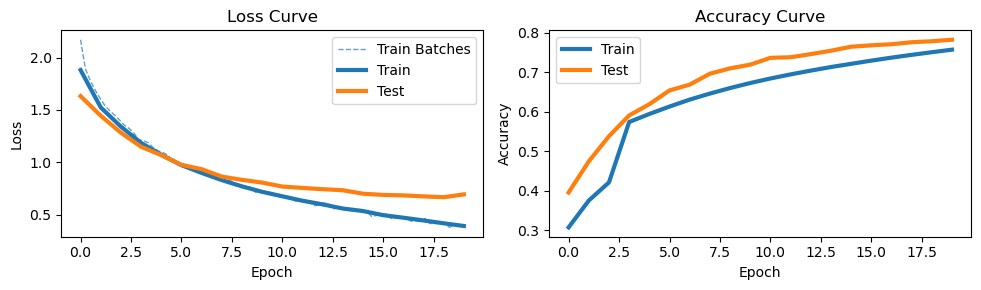

In [24]:
trainer.train(epochs=17, use_gpu=USE_GPU)
trainer.plot()

Epoch 21 :   0%|          | 0/391 [00:00<?, ?it/s]

[21,    97] loss: 0.367
[21,   194] loss: 0.361
[21,   291] loss: 0.369
[21,   388] loss: 0.375
Train Loss : 0.36769345962940275
Train Accuracy : 87.01 %
Val Loss : 0.6796363995799536
Accuracy of the network on the 10000 test images: 78.15 %


Epoch 22 :   0%|          | 0/391 [00:00<?, ?it/s]

[22,    97] loss: 0.342
[22,   194] loss: 0.335
[22,   291] loss: 0.350
[22,   388] loss: 0.357
Train Loss : 0.3456956490759959
Train Accuracy : 87.30 %
Val Loss : 0.6879615131058271
Accuracy of the network on the 10000 test images: 78.35 %


Epoch 23 :   0%|          | 0/391 [00:00<?, ?it/s]

[23,    97] loss: 0.306
[23,   194] loss: 0.320
[23,   291] loss: 0.329
[23,   388] loss: 0.326
Train Loss : 0.3203123267882925
Train Accuracy : 87.77 %
Val Loss : 0.6761385198635391
Accuracy of the network on the 10000 test images: 78.73 %


Epoch 24 :   0%|          | 0/391 [00:00<?, ?it/s]

[24,    97] loss: 0.296
[24,   194] loss: 0.298
[24,   291] loss: 0.304
[24,   388] loss: 0.299
Train Loss : 0.2991283302340666
Train Accuracy : 88.16 %
Val Loss : 0.6776608579520937
Accuracy of the network on the 10000 test images: 79.19 %


Epoch 25 :   0%|          | 0/391 [00:00<?, ?it/s]

[25,    97] loss: 0.271
[25,   194] loss: 0.273
[25,   291] loss: 0.287
[25,   388] loss: 0.295
Train Loss : 0.2816550236986116
Train Accuracy : 88.53 %
Val Loss : 0.7049153722539733
Accuracy of the network on the 10000 test images: 78.81 %


Epoch 26 :   0%|          | 0/391 [00:00<?, ?it/s]

[26,    97] loss: 0.259
[26,   194] loss: 0.266
[26,   291] loss: 0.280
[26,   388] loss: 0.284
Train Loss : 0.2720843126897312
Train Accuracy : 88.84 %
Val Loss : 0.6708666984039017
Accuracy of the network on the 10000 test images: 79.48 %


Epoch 27 :   0%|          | 0/391 [00:00<?, ?it/s]

[27,    97] loss: 0.248
[27,   194] loss: 0.252
[27,   291] loss: 0.250
[27,   388] loss: 0.267
Train Loss : 0.25349397909687
Train Accuracy : 89.16 %
Val Loss : 0.676314732319192
Accuracy of the network on the 10000 test images: 79.80 %


Epoch 28 :   0%|          | 0/391 [00:00<?, ?it/s]

[28,    97] loss: 0.224
[28,   194] loss: 0.228
[28,   291] loss: 0.243
[28,   388] loss: 0.252
Train Loss : 0.2367437172423848
Train Accuracy : 89.47 %
Val Loss : 0.7052334003810641
Accuracy of the network on the 10000 test images: 79.76 %


Epoch 29 :   0%|          | 0/391 [00:00<?, ?it/s]

[29,    97] loss: 0.209
[29,   194] loss: 0.216
[29,   291] loss: 0.232
[29,   388] loss: 0.215
Train Loss : 0.21820116367029108
Train Accuracy : 89.78 %
Val Loss : 0.7283503069907804
Accuracy of the network on the 10000 test images: 79.66 %


Epoch 30 :   0%|          | 0/391 [00:00<?, ?it/s]

[30,    97] loss: 0.191
[30,   194] loss: 0.210
[30,   291] loss: 0.209
[30,   388] loss: 0.204
Train Loss : 0.20382193260638
Train Accuracy : 90.08 %
Val Loss : 0.6975331751606132
Accuracy of the network on the 10000 test images: 79.93 %


Epoch 31 :   0%|          | 0/391 [00:00<?, ?it/s]

[31,    97] loss: 0.183
[31,   194] loss: 0.193
[31,   291] loss: 0.183
[31,   388] loss: 0.206
Train Loss : 0.19068670943569954
Train Accuracy : 90.36 %
Val Loss : 0.7452862047696416
Accuracy of the network on the 10000 test images: 79.16 %


Epoch 32 :   0%|          | 0/391 [00:00<?, ?it/s]

[32,    97] loss: 0.163
[32,   194] loss: 0.169
[32,   291] loss: 0.191
[32,   388] loss: 0.187
Train Loss : 0.17804466631939952
Train Accuracy : 90.64 %
Val Loss : 0.7359523976905437
Accuracy of the network on the 10000 test images: 80.06 %


Epoch 33 :   0%|          | 0/391 [00:00<?, ?it/s]

[33,    97] loss: 0.161
[33,   194] loss: 0.171
[33,   291] loss: 0.166
[33,   388] loss: 0.180
Train Loss : 0.16977797143752008
Train Accuracy : 90.90 %
Val Loss : 0.7403460635414606
Accuracy of the network on the 10000 test images: 80.23 %


Epoch 34 :   0%|          | 0/391 [00:00<?, ?it/s]

[34,    97] loss: 0.149
[34,   194] loss: 0.163
[34,   291] loss: 0.169
[34,   388] loss: 0.164
Train Loss : 0.1610676008169456
Train Accuracy : 91.14 %
Val Loss : 0.7303738669504093
Accuracy of the network on the 10000 test images: 80.42 %


Epoch 35 :   0%|          | 0/391 [00:00<?, ?it/s]

[35,    97] loss: 0.139
[35,   194] loss: 0.144
[35,   291] loss: 0.145
[35,   388] loss: 0.160
Train Loss : 0.14784928867617225
Train Accuracy : 91.39 %
Val Loss : 0.7362351930594142
Accuracy of the network on the 10000 test images: 80.81 %


Epoch 36 :   0%|          | 0/391 [00:00<?, ?it/s]

[36,    97] loss: 0.135
[36,   194] loss: 0.141
[36,   291] loss: 0.150
[36,   388] loss: 0.140
Train Loss : 0.14148119591233677
Train Accuracy : 91.62 %
Val Loss : 0.7544528193111661
Accuracy of the network on the 10000 test images: 80.64 %


Epoch 37 :   0%|          | 0/391 [00:00<?, ?it/s]

[37,    97] loss: 0.127
[37,   194] loss: 0.127
[37,   291] loss: 0.131
[37,   388] loss: 0.153
Train Loss : 0.13427789370669885
Train Accuracy : 91.83 %
Val Loss : 0.7583090610141996
Accuracy of the network on the 10000 test images: 80.30 %


Epoch 38 :   0%|          | 0/391 [00:00<?, ?it/s]

[38,    97] loss: 0.119
[38,   194] loss: 0.118
[38,   291] loss: 0.122
[38,   388] loss: 0.126
Train Loss : 0.12144365451296273
Train Accuracy : 92.04 %
Val Loss : 0.7524085863481594
Accuracy of the network on the 10000 test images: 80.98 %


Epoch 39 :   0%|          | 0/391 [00:00<?, ?it/s]

[39,    97] loss: 0.116
[39,   194] loss: 0.109
[39,   291] loss: 0.123
[39,   388] loss: 0.129
Train Loss : 0.11959598601207404
Train Accuracy : 92.24 %
Val Loss : 0.7941339012188248
Accuracy of the network on the 10000 test images: 80.62 %


Epoch 40 :   0%|          | 0/391 [00:00<?, ?it/s]

[40,    97] loss: 0.106
[40,   194] loss: 0.113
[40,   291] loss: 0.113
[40,   388] loss: 0.125
Train Loss : 0.11472038663161532
Train Accuracy : 92.42 %
Val Loss : 0.776219069203244
Accuracy of the network on the 10000 test images: 80.75 %
Finished Training


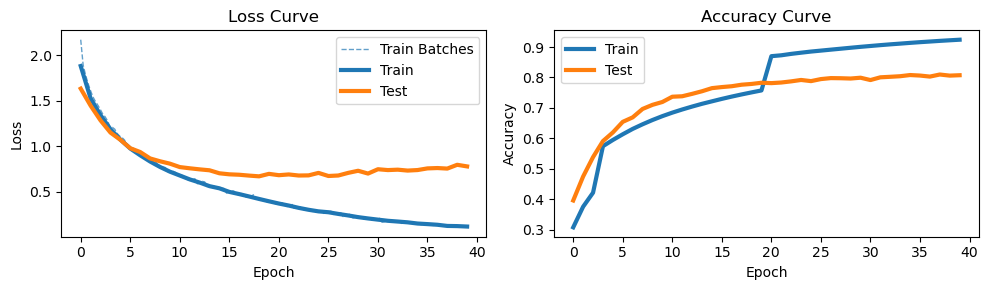

In [25]:
trainer.train(epochs=20, use_gpu=USE_GPU)
trainer.plot()

## Experiment

In [ ]:
class Model2(nn.Module):

  def __init__(self, channels, kernel_size=HIDDEN_CONV_KERNEL, n=N, debug=False):
    super(Model2, self).__init__()
	
    self.debug=debug
    
    self.convs = nn.ModuleList(
        nn.Sequential(
            nn.Conv2d(in_channels=channels[i], out_channels=channels[i+1], kernel_size=kernel_size),
            #nn.BatchNorm2d(num_features=channels[i+1]),
            nn.ReLU(),
            nn.MaxPool2d(2, 1),
        )
        for i in range(n)
    )
    self.img_sizes = find_img_size(initial_img_size=IMG_DIM, depth=n+1, kernel_size=kernel_size, stride=1, pool=2)
    print(f"{self.img_sizes=}")
    
    #self.spaitial_average_pool = nn.AvgPool2d(kernel_size=self.img_sizes[-1])
    self.spaitial_average_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    self.linear = nn.Sequential(
        nn.Linear(in_features=channels[-1], out_features=len(CLASSES), bias=False),
    )

  def set_debug(self, debug=True):
    self.debug = debug

  def forward(self, x):

    #x = self.conv1(x)
    #if self.debug: print(f"M: {x.shape=}")
    #x = self.conv2(x)
    #if self.debug: print(f"M: {x.shape=}")
    #x = self.conv3(x)
    #if self.debug: print(f"M: {x.shape=}")
    
    for conv in self.convs:
        x = conv(x)
        if self.debug: print(f"M conv: {x.shape=}")
    
    f = self.spaitial_average_pool(x).reshape(x.shape[0], -1)
    if self.debug: print(f"M: {f.shape=}")

    out = self.linear(f)
    if self.debug: print(f"M: {out.shape=}")

    return out